In [2]:
"""
R001_Fall_2023_AI_Reproducibility__
|
R001_AWS_MTurk_process_results.ipynb
Created on Fri Mar 22 01:14:11 2024
@author: Rochana Obadage
"""

In [1]:
!python --version

## ``Summarizing and Post processing the crowdsourced labels`` 

In [2]:
import os
import json
import glob
import pandas as pd
from collections import Counter

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

## post-processing MTurk batches

In [2]:
# all_csv_unique
for idx, csv_file in enumerate(all_csv_unique):
    df_ = pd.read_csv(csv_file)
    filename = os.path.basename(csv_file).replace('_results','_simplified')
    batch_name = os.path.basename(csv_file).replace('_results','').replace('.csv','')
    
    df_30_new = pd.DataFrame(columns=['hit_id','worker_id',
                                  'work_time_in_seconds','input_index','input_context',
                                      'input_file_key','input_first_author','task_answers','batch'])

    for index, row in df_.iterrows():
        temp_row = {"hit_id": row['HITId'],
                     'worker_id':row['WorkerId'] ,
                     'work_time_in_seconds': row['WorkTimeInSeconds'],
                     'input_index': row['Input.index'],
                     'input_context': row['Input.context'] ,
                     'input_file_key': row['Input.file_key'] ,
                     'input_first_author': row['Input.first_author'] ,
                     'task_answers':eval(row['Answer.taskAnswers'])[0]['citation-contexts']['label'],
                     'batch':batch_name
                    }

        df_30_new.loc[len(df_30_new)] = temp_row

    df_10_from_30 = pd.DataFrame(columns=['input_index','input_context','input_file_key','input_first_author',
                                          'worker_id_w1','work_time_in_seconds_w1','label_w1',
                                          'worker_id_w2','work_time_in_seconds_w2','label_w2',
                                          'worker_id_w3','work_time_in_seconds_w3','label_w3',
                                          'batch','majority_vote','majority_agreement'])

    for hit_id in set(df_30_new['hit_id']):
        df_temp = df_30_new[df_30_new['hit_id'] == hit_id].reset_index(drop=True)
        temp_row = {'hit_id':hit_id,'input_index':df_temp['input_index'][0],
                    'input_context':df_temp['input_context'][0],'input_file_key':df_temp['input_file_key'][0],
                    'input_first_author':df_temp['input_first_author'][0],'batch':df_temp['batch'][0]}

        for i, row in df_temp.iterrows():
            worker = {f'worker_id_w{int(i+1)}':row['worker_id'],
                      f'work_time_in_seconds_w{i+1}':row['work_time_in_seconds'],
                      f'label_w{i+1}':row['task_answers']}
            temp_row.update(worker)

        label_counts = Counter([temp_row['label_w1'],temp_row['label_w2'],temp_row['label_w3']])

        # Find the label with the highest count (majority vote)
        majority_vote = label_counts.most_common(1)[0][0]        
        agreement = label_counts.most_common(1)[0][1]        
            
        temp_row.update({'majority_vote':majority_vote})
        temp_row.update({'majority_agreement':agreement})           
            
        df_10_from_30.loc[len(df_10_from_30)] = temp_row 
        
    print(filename, end='\n\n')
    
    df_10_from_30.to_csv(f'{filename}',index=False)

## Sample creation

In [55]:
import pandas as pd
import glob

# Set the directory path for the CSV files
csv_dir = 'AWS_labelling/Mechanical_Turk/processed_results/*.csv'

# Initialize an empty DataFrame to hold the sampled rows
combined_df = pd.DataFrame()

# Define selection requirements for each label
selection_requirements = {
    'Neutral': {2: 2, 3: 1},
    'Positive': {2: 2, 3: 2},
    'Negative': {2: 2, 3: 1}
}

# Loop through each CSV file in the directory
for file in glob.glob(csv_dir):
    # Read the CSV file
    df = pd.read_csv(file)
    
    # Initialize a DataFrame to store selected rows for the current file
    file_sampled_df = pd.DataFrame()

    # Loop through each category and majority voting requirement
    for label, vote_counts in selection_requirements.items():
        for vote_value, count in vote_counts.items():
            # Filter the DataFrame for the current label and vote value, then sample the required rows
            label_vote_df = df[(df['majority_vote'] == label) & (df['majority_agreement'] == vote_value)]
            # sampled_rows = label_vote_df.sample(n=count, random_state=42)  # Set random_state for reproducibility

            # Check if there are enough rows to sample
            available_rows = len(label_vote_df)
            if available_rows >= count:
                # If sufficient rows are available, sample the required number
                sampled_rows = label_vote_df.sample(n=count, random_state=42)
            else:
                # If not enough rows are available, sample all available rows
                sampled_rows = label_vote_df            
            
            
            file_sampled_df = pd.concat([file_sampled_df, sampled_rows], ignore_index=True)
    
    # Append the selected rows from this file to the combined DataFrame
    combined_df = pd.concat([combined_df, file_sampled_df], ignore_index=True)

# Save the final combined DataFrame to a new CSV file
combined_df.to_csv(r'AWS_labelling/Mechanical_Turk/selected_random_sample_from_mturk_crowdsourcing.csv', index=False)

print("Sampled combined CSV created as 'selected_random_sample_from_mturk_crowdsourcing.csv'")

Sampled combined CSV created as 'selected_random_sample_from_mturk_crowdsourcing.csv'


### confusion matrix for manual labelled sample - selected from MTurk crowdsourcing

Overall Accuracy: 93.85%

Per-class Metrics:
  Negative:
    Precision: 88.71%
    Recall: 100.00%
    F1-Score: 94.02%
  Neutral:
    Precision: 96.15%
    Recall: 86.21%
    F1-Score: 90.91%
  Positive:
    Precision: 95.19%
    Recall: 97.06%
    F1-Score: 96.12%

Overall Metrics:
  Macro Precision: 93.35%
  Macro Recall: 94.42%
  Macro F1-Score: 93.68%
  Weighted F1-Score: 93.79%


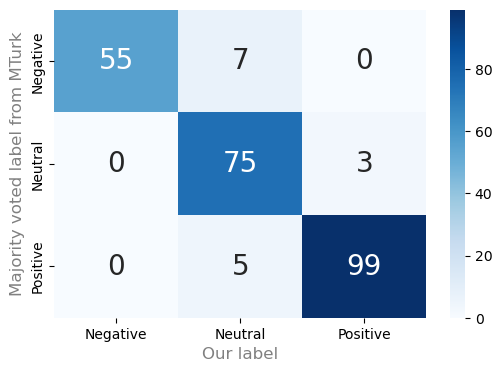

In [11]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df_ = pd.read_csv(r'dataset/selected_random_sample_manually_labelled.csv')

# Define the labels
labels = ['Negative', 'Neutral', 'Positive']

# Compute the confusion matrix
cm = confusion_matrix(df_['majority_vote'], df_['lemos_label'], labels=labels)

# Classification report for all metrics
report = classification_report(df_['lemos_label'], df_['majority_vote'], labels=labels, output_dict=True)

# Overall accuracy
overall_accuracy = accuracy_score(df_['lemos_label'], df_['majority_vote'])
print(f"Overall Accuracy: {overall_accuracy:.2%}")

# Display per-class precision, recall, and F1-score
print("\nPer-class Metrics:")
for label in labels:
    print(f"  {label}:")
    print(f"    Precision: {report[label]['precision']:.2%}")
    print(f"    Recall: {report[label]['recall']:.2%}")
    print(f"    F1-Score: {report[label]['f1-score']:.2%}")

# Display overall metrics
print("\nOverall Metrics:")
print(f"  Macro Precision: {report['macro avg']['precision']:.2%}")
print(f"  Macro Recall: {report['macro avg']['recall']:.2%}")
print(f"  Macro F1-Score: {report['macro avg']['f1-score']:.2%}")
# print(f"  Micro Precision/Recall/F1-Score: {report['micro avg']['precision']:.2%}")
print(f"  Weighted F1-Score: {report['weighted avg']['f1-score']:.2%}")

# Plot the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels, annot_kws={"size": 20})
plt.xlabel('Our label', c='gray',fontsize=12)
plt.ylabel('Majority voted label from MTurk', c='gray',fontsize=12)
plt.savefig(r'plots/technical_validation_confusion_matrix.pdf', bbox_inches='tight', pad_inches=0.5)
plt.show()

In [37]:
label_counts = df_['lemos_label'].value_counts()

# Initialize counts for each label
correct_negative = sum(1 for true, pred in zip(df_['lemos_label'], df_['majority_vote']) if true == pred and true == "Negative")
correct_positive = sum(1 for true, pred in zip(df_['lemos_label'], df_['majority_vote']) if true == pred and true == "Positive")
correct_neutral = sum(1 for true, pred in zip(df_['lemos_label'], df_['majority_vote']) if true == pred and true == "Neutral")

# Print results
print(f"Correct 'Negative' predictions: {correct_negative}/{label_counts['Negative']}")
print(f"Correct 'Positive' predictions: {correct_positive}/{label_counts['Positive']}")
print(f"Correct 'Neutral' predictions: {correct_neutral}/{label_counts['Neutral']}")

Correct 'Negative' predictions: 55/55
Correct 'Positive' predictions: 99/102
Correct 'Neutral' predictions: 75/87


In [38]:
report

{'Negative': {'precision': 0.8870967741935484,
  'recall': 1.0,
  'f1-score': 0.9401709401709402,
  'support': 55},
 'Neutral': {'precision': 0.9615384615384616,
  'recall': 0.8620689655172413,
  'f1-score': 0.9090909090909091,
  'support': 87},
 'Positive': {'precision': 0.9519230769230769,
  'recall': 0.9705882352941176,
  'f1-score': 0.9611650485436893,
  'support': 102},
 'accuracy': 0.9385245901639344,
 'macro avg': {'precision': 0.9335194375516956,
  'recall': 0.9442190669371197,
  'f1-score': 0.9368089659351795,
  'support': 244},
 'weighted avg': {'precision': 0.9407390269698572,
  'recall': 0.9385245901639344,
  'f1-score': 0.9378653514416684,
  'support': 244}}

In [40]:
from sklearn.metrics import precision_recall_fscore_support

# Precision, recall, f1-score, and support for each label
labels = ['Negative', 'Neutral', 'Positive']
metrics = report

# Extracting true positives (TP), false positives (FP), false negatives (FN), and true negatives (TN)
true_positives = []
false_positives = []
false_negatives = []
true_negatives = []

# Loop through each class and calculate the needed metrics
for label in labels:
    precision = metrics[label]['precision']
    recall = metrics[label]['recall']
    f1_score = metrics[label]['f1-score']
    support = metrics[label]['support']
    
    # For micro averaging: we accumulate TP, FP, FN for each label
    TP = recall * support  # True Positives = Recall * Support
    FP = (1 - precision) * (support)  # False Positives = (1 - Precision) * Support
    FN = (1 - recall) * support  # False Negatives = (1 - Recall) * Support
    TN = support - TP - FP - FN  # True Negatives
    
    true_positives.append(TP)
    false_positives.append(FP)
    false_negatives.append(FN)
    true_negatives.append(TN)

# Calculate micro averages for Precision, Recall, and F1-score
total_TP = sum(true_positives)
total_FP = sum(false_positives)
total_FN = sum(false_negatives)
total_TN = sum(true_negatives)

# Micro-averaged Precision
micro_precision = total_TP / (total_TP + total_FP)

# Micro-averaged Recall
micro_recall = total_TP / (total_TP + total_FN)

# Micro-averaged F1-Score
micro_f1 = 2 * (micro_precision * micro_recall) / (micro_precision + micro_recall)

# Print results
print(f"Micro-average Precision: {micro_precision:.4f}")
print(f"Micro-average Recall: {micro_recall:.4f}")
print(f"Micro-average F1-Score: {micro_f1:.4f}")

Micro-average Precision: 0.9406
Micro-average Recall: 0.9385
Micro-average F1-Score: 0.9396


In [43]:
report['micro-avg'] = {'precision': f'{micro_precision:.6f}',
  'recall': f'{micro_recall:.6f}',
  'f1-score': f'{micro_f1:.6f}',
  'support': 244.0}

In [44]:
report_df = pd.DataFrame(report).transpose()
report_df

,precision,recall,f1-score,support
Negative,0.887097,1.0,0.940171,55.0
Neutral,0.961538,0.862069,0.909091,87.0
Positive,0.951923,0.970588,0.961165,102.0
accuracy,0.938525,0.938525,0.938525,0.938525
macro avg,0.933519,0.944219,0.936809,244.0
weighted avg,0.940739,0.938525,0.937865,244.0
micro-avg,0.940608,0.938525,0.939565,244.0


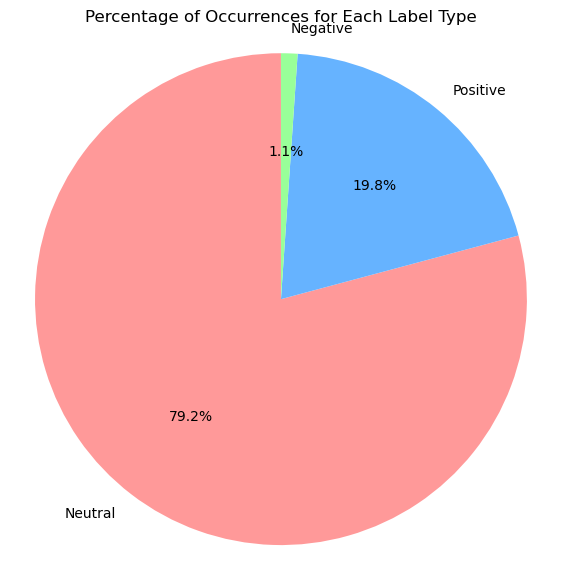

Neutral     0.791668
Positive    0.197530
Negative    0.010802
Name: majority_vote, dtype: float64

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

# Read the CSV file into a DataFrame
csv_file = r'dataset/cc25k_dataset.csv'
df = pd.read_csv(csv_file)

# Calculate the percentage of occurrences for each label type in the 'majority_vote' column
label_counts = df['majority_vote'].value_counts(normalize=True) * 100

# Plot the results as a pie chart
plt.figure(figsize=(7, 7))
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', startangle=90, colors=['#ff9999','#66b3ff','#99ff99','#ffcc99'])
plt.title('Percentage of Occurrences for Each Label Type')
plt.axis('equal')  # Equal aspect ratio ensures that pie chart is circular
plt.show()

label_counts
df['majority_vote'].value_counts(normalize=True)

In [3]:
df['majority_vote'].value_counts()

Neutral     20448
Positive     5102
Negative      279
Name: majority_vote, dtype: int64